# Import Library

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import zipfile
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from torch import optim
from tqdm import tqdm
import warnings

from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Management

In [ ]:
file_path = '/content/drive/MyDrive/Computer Vision/PROJECT/dataset_hand_gesture/hand_craft_dataset/npy_dataset.zip'

# Unzip the file to a specific destination
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data')

# Point Net

In [ ]:
class PointNet(nn.Module):
    def __init__(self, num_classes):
        super(PointNet, self).__init__()
        self.mlp = nn.Sequential(
            nn.Conv1d(3, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 1024, 1),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )

        # Global max pooling
        self.global_max_pool = nn.MaxPool1d(21)


        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        #self.dropout()
        # x: input point cloud tensor of shape (batch_size, num_points, num_channels)

        # Permute the tensor to have shape (batch_size, num_channels, num_points)
        x = x.permute(0, 2, 1)

        # Apply shared MLP
        x = self.mlp(x)

        # Global max pooling
        x = self.global_max_pool(x)
        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Apply fully connected layers
        x = self.fc_layers(x)

        return x

# Train Validation Test

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

dataset_path = '/content/sample_data/npy_dataset'

# Definizione delle etichette attese
expected_labels = [
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
    'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
    'del', 'nothing', 'space'
]

class PointsDataSet(Dataset):
    def __init__(self, path, items, char2int):
        self.path = path
        self.items = items
        self.char2int = char2int

    def __getitem__(self, item):
        label, file_name = self.items[item]
        points = np.load(os.path.join(self.path, label, file_name))
        points = np.array(points)

        if label not in self.char2int:
            raise ValueError(f"Label '{label}' not found in char2int dictionary.")

        return points, self.char2int[label]

    def __len__(self):
        return len(self.items)

    def collate_fn(self, batch):
        ims, classes = list(zip(*batch))

        ims = torch.stack([torch.Tensor(im) for im in ims]).float().to(device)
        ce_masks = torch.tensor(classes).long().to(device)

        return ims, ce_masks


def split_files(path, divs):
    if divs[0] + divs[1] + divs[2] != 1.0:
        print(f'Wrong divisions: Train={divs[0]} Validation={divs[1]} Test={divs[2]} Total={divs[0] + divs[1] + divs[2]}')
        sys.exit()

    items = []
    labels = set(expected_labels)  # Includi tutte le etichette attese
    for root, dirs, files in os.walk(path, topdown=True):
        for file in files:
            label = os.path.basename(root)
            items.append((label, file))
            labels.add(label)

    np.random.shuffle(items)

    # Creazione del dizionario char2int dinamicamente includendo tutte le etichette attese
    char2int = {label: idx for idx, label in enumerate(sorted(labels))}

    size = len(items)
    train = int(size * divs[0])
    val = int(size * divs[1])
    test = int(size * divs[2])
    total = train + test + val
    train = train + (size - total)

    # train - validation - test
    return items[:train], items[train:train+val], items[train+val:], char2int

batch_size = 32
train_percent = 0.7
validation_percent = 0.15
test_percent = 0.15
train_files, val_files, test_files, char2int = split_files(dataset_path, (train_percent, validation_percent, test_percent))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_ds = PointsDataSet(dataset_path, train_files, char2int)
val_ds = PointsDataSet(dataset_path, val_files, char2int)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=train_ds.collate_fn, drop_last=False)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True, collate_fn=val_ds.collate_fn, drop_last=False)
test_ds = PointsDataSet(dataset_path, test_files, char2int)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True, collate_fn=test_ds.collate_fn, drop_last=False)


# Train model

Current epoch: 0


Loss train 0.03370361574864109 Loss val 0.02535587625833626 Acc train 0.9917207710533799 Acc val 0.991014799154334
Current epoch: 1


Loss train 0.009931164981911824 Loss val 0.0007787266115030608 Acc train 0.9972428783547135 Acc val 0.9997577519379846
Current epoch: 2


Loss train 0.005471785836759574 Loss val 0.003606334113159149 Acc train 0.99832496602748 Acc val 0.998612579281184
Current epoch: 3


Loss train 0.0018420956871264135 Loss val 0.0002130212879214201 Acc train 0.9994353641380846 Acc val 0.9999119097956307
Current epoch: 4


Loss train 0.0015821755694666987 Loss val 4.0937633089387654e-05 Acc train 0.9997766621384973 Acc val 1.0


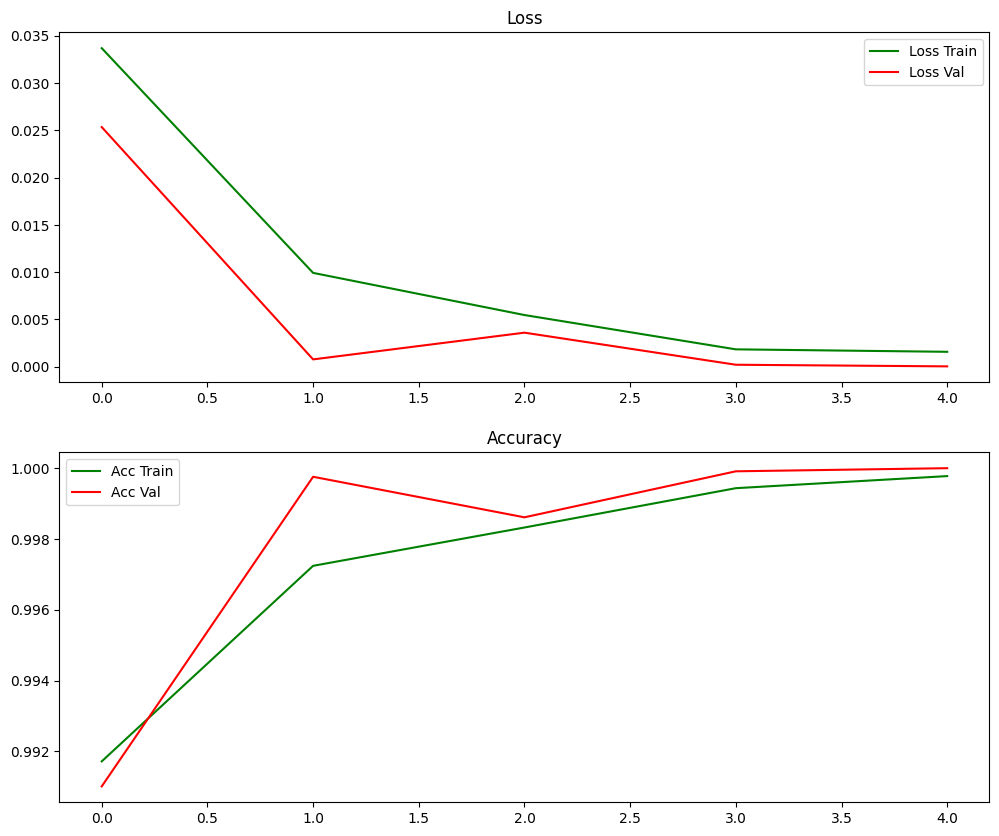

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train_batch(model, data, optmz, loss_fn):
    model.train()
    points, classes = data
    _masks = model(points)
    optmz.zero_grad()
    loss, acc = loss_fn(_masks, classes)
    loss.backward()
    optmz.step()

    return loss.item(), acc.item()


@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)

    return loss.item(), acc.item()


def pointnet_loss(preds, targets):
    ce = nn.CrossEntropyLoss()
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc


def main():
    model_path = "/content/drive/MyDrive/Computer Vision/PROJECT/dataset_hand_gesture/hand_craft_dataset/GraphNet/model_2"
    results_path = "/content/drive/MyDrive/Computer Vision/PROJECT/dataset_hand_gesture/hand_craft_dataset/GraphNet/result_2"
    model_name = "point_net_model.pth"
    os.makedirs(model_path, exist_ok=True)
    os.makedirs(results_path, exist_ok=True)

    n_epochs = 5
    learning_rate = 0.001
    optimizer_name = "Adam"

    model = PointNet(len(char2int)).to(device)
    loss_function = pointnet_loss
    optimizer_class = getattr(optim, optimizer_name)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=0, threshold=0.001, min_lr=1e-5, threshold_mode='abs')

    loss_train_all = []
    acc_train_all = []
    loss_val_all = []
    acc_val_all = []

    for epoch in range(n_epochs):
        print(f'Current epoch: {epoch}')
        loss_ep = []
        acc_ep = []

        for points, classes in tqdm(train_dl, desc="Training", leave=False):
            loss, acc = train_batch(model, (points, classes), optimizer, loss_function)
            loss_ep.append(loss)
            acc_ep.append(acc)
        loss_train_all.append(np.mean(loss_ep))
        acc_train_all.append(np.mean(acc_ep))

        loss_ep = []
        acc_ep = []

        for points, classes in tqdm(val_dl, desc="Validation", leave=False):
            loss, acc = validate_batch(model, (points, classes), loss_function)
            loss_ep.append(loss)
            acc_ep.append(acc)
        loss_val_all.append(np.mean(loss_ep))
        acc_val_all.append(np.mean(acc_ep))

        val_loss = np.mean(loss_ep)
        scheduler.step(val_loss)

        print(f'Loss train {loss_train_all[-1]} Loss val {loss_val_all[-1]} Acc train {acc_train_all[-1]} Acc val {acc_val_all[-1]}')
        with open(os.path.join(results_path, 'status.csv'), 'a') as f:
            f.write(f'{loss_train_all[-1]}; {loss_val_all[-1]}; {acc_train_all[-1]}; {acc_val_all[-1]}\n')

        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), os.path.join(model_path, model_name))

    torch.save(model.state_dict(), os.path.join(model_path, model_name))

    fig, axs = plt.subplots(2, 1, figsize=(12, 10))
    axs[0].plot(loss_train_all, color='green', label='Loss Train')
    axs[0].plot(loss_val_all, color='red', label='Loss Val')
    axs[0].set_title("Loss")
    axs[0].legend()

    axs[1].plot(acc_train_all, color='green', label='Acc Train')
    axs[1].plot(acc_val_all, color='red', label='Acc Val')
    axs[1].set_title("Accuracy")
    axs[1].legend()

    plt.savefig(os.path.join(results_path, f'metrics_point_net_{n_epochs}epochs_{learning_rate}lr.png'))
    plt.show()


if __name__ == '__main__':
    main()


# Test of model


Accuracy: 0.9652704369274137
Precision: 0.9652704369274137
Recall: 0.9652704369274137
F1 Score: 0.9652704369274137
Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00      1604
           B       1.00      1.00      1.00      1614
           C       1.00      1.00      1.00      1611
           D       1.00      1.00      1.00      1653
           E       1.00      1.00      1.00      1627
           F       1.00      1.00      1.00      1601
           G       1.00      1.00      1.00      1605
           H       1.00      1.00      1.00      1580
           I       1.00      1.00      1.00      1641
           J       1.00      1.00      1.00      1642
           K       1.00      1.00      1.00      1572
           L       1.00      1.00      1.00      1673
           M       1.00      1.00      1.00      1606
           N       1.00      1.00      1.00      1630
           O       1.00      1.00      1.00      16

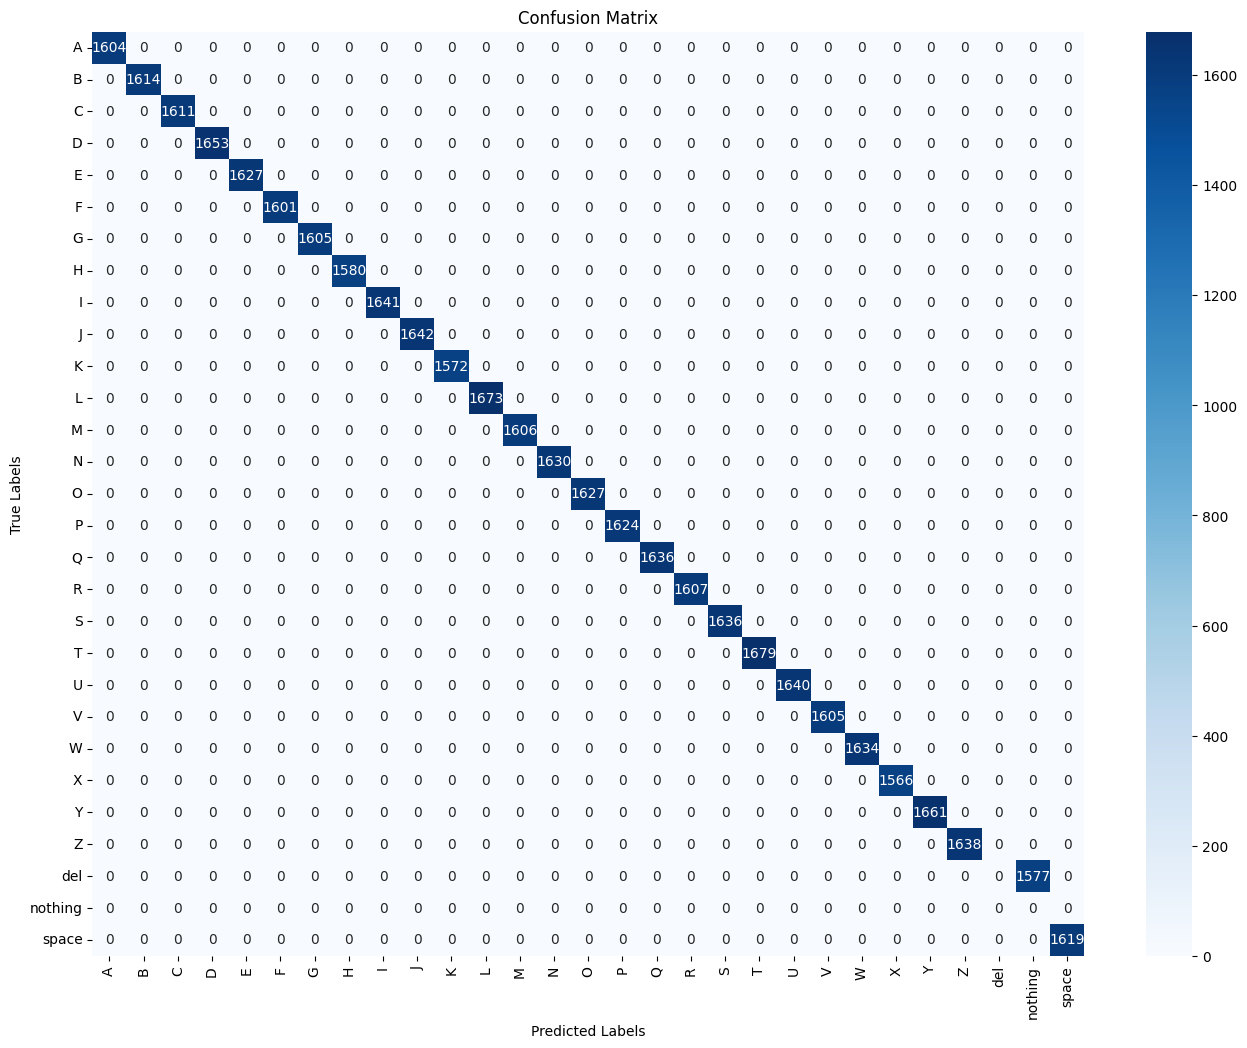

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings("ignore")
model_path = '/content/drive/MyDrive/Computer Vision/PROJECT/dataset_hand_gesture/hand_craft_dataset/GraphNet/model/point_net_model.pth'
model = PointNet(num_classes=29)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

label_dict = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J',
    10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S',
    19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'del', 27: 'nothing', 28: 'space'
}

all_preds = []
all_labels = []

with torch.no_grad():
    for data in test_dl:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
class_report = classification_report(all_labels, all_preds, target_names=[label_dict[i] for i in range(29)])
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Classification Report:\n{class_report}')

plt.figure(figsize=(16, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[label_dict[i] for i in range(29)], yticklabels=[label_dict[i] for i in range(29)])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()